<a href="https://colab.research.google.com/github/LauJohansson/HotdogNotHotdog_and_StreetViewHouseNumbers/blob/master/Hotdog_not_hotdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import datetime
import torchvision

We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


# Loading data

We download the dataset when the notebook starts, because it's no longer in the local session

In [ ]:
if not os.path.exists('./hotdog_nothotdog'):
  import gdown
  url = 'https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk'
  gdown.download(url, './hotdog_nothotdog.zip', quiet=False)
  !unzip ./hotdog_nothotdog.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk
To: /content/hotdog_nothotdog.zip
271MB [00:01, 176MB/s]


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use

In [ ]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 5000
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
len(testset)

1862

In [ ]:
size = 128

# training data normal
train_transform = transforms.Compose([transforms.Resize((size, size)), # zooming in (making the (not) hot-dogs bigger) 
                                      transforms.ToTensor()])


# training data augmented
train_transform_aug = transforms.Compose([transforms.Resize((size, size)),
                                          transforms.RandomRotation(30), # rotations
                                          transforms.RandomHorizontalFlip(p=0.5), # horizontal flip
                                          transforms.CenterCrop((size, size)), # zooming in (making the (not) hot-dogs bigger) 
                                          transforms.ToTensor()])


train_transform_aug_2 = transforms.Compose([transforms.RandomApply([
                                                    transforms.RandomRotation(30), # rotations
                                                    transforms.RandomHorizontalFlip(p=0.5), # horizontal flip
                                                    transforms.CenterCrop((size, size))], p=0.5), # zooming in (making the (not) hot-dogs bigger) 
                                                    transforms.Resize((size, size)),
                                                    transforms.ToTensor()])


# https://pytorch.org/docs/stable/torchvision/transforms.html


# test data normal
test_transform  = transforms.Compose([transforms.Resize((size, size)), 
                                      transforms.ToTensor()])

batch_size = 64

# combining the two training sets
trainset1 = Hotdog_NotHotdog(train=True, transform=train_transform)
trainset2 = Hotdog_NotHotdog(train=True, transform=train_transform_aug)
trainset3 = Hotdog_NotHotdog(train=True, transform=train_transform_aug_2)
trainset = ConcatDataset([trainset1, trainset2, trainset3])

# loading train
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

# loading test
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

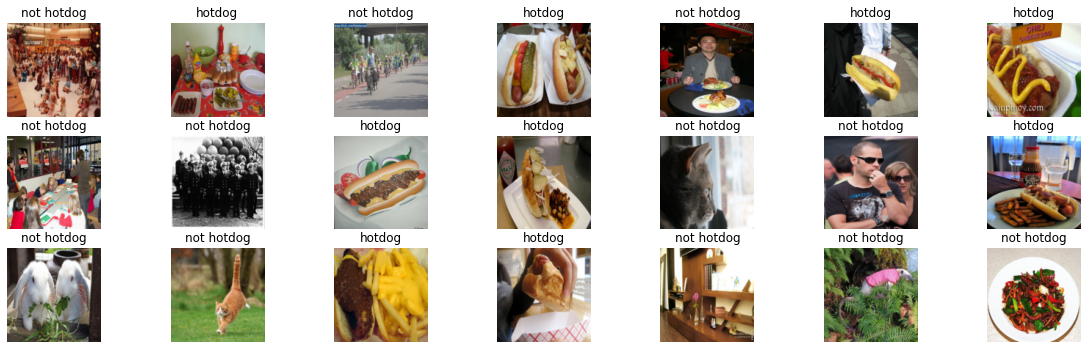

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Model

Now create a model and train it!


In [ ]:
# torch.save(model.state_dict(), PATH)   # Save state

In [ ]:
def Padding(kernel_size):
  padding = int((kernel_size-1)/2)
  return padding

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=Padding(kernel_size)),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=Padding(kernel_size)),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=Padding(kernel_size)),
            nn.ReLU())

        self.fully_connected = nn.Sequential(
            nn.Linear(64*64*out_channels, num_features),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_features, no_targets),
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [ ]:
in_channels = 3
out_channels = 18
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)#, weight_decay=0.5)

In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs):
    def loss_fun(output, target):
        return F.nll_loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

# Best results

## Pre data augmentation

### w/batchnorm2d + dropout1d(0.5), 75.9%


Loss train: 0.729	 test: 0.662	 Accuracy train: 60.6%	 test: 66.2%



Loss train: 0.506	 test: 0.551	 Accuracy train: 76.0%	 test: 73.3%



Loss train: 0.436	 test: 0.548	 Accuracy train: 80.1%	 test: 74.0%



Loss train: 0.394	 test: 0.553	 Accuracy train: 82.4%	 test: 73.2%



Loss train: 0.328	 test: 0.532	 Accuracy train: 86.8%	 test: 74.9%



Loss train: 0.296	 test: 0.557	 Accuracy train: 88.5%	 test: 75.2%



Loss train: 0.239	 test: 0.609	 Accuracy train: 90.9%	 test: 72.2%



Loss train: 0.214	 test: 0.547	 Accuracy train: 92.1%	 test: 75.9%



Loss train: 0.171	 test: 0.569	 Accuracy train: 94.2%	 test: 75.9%



Loss train: 0.137	 test: 0.610	 Accuracy train: 95.5%	 test: 75.9%



Loss train: 0.110	 test: 0.646	 Accuracy train: 97.6%	 test: 75.3%



Loss train: 0.083	 test: 0.644	 Accuracy train: 98.4%	 test: 75.7%



Loss train: 0.070	 test: 0.683	 Accuracy train: 98.8%	 test: 75.5%



Loss train: 0.054	 test: 0.712	 Accuracy train: 99.2%	 test: 75.6%



Loss train: 0.045	 test: 0.759	 Accuracy train: 99.3%	 test: 75.0%



Text(0, 0.5, 'Loss')

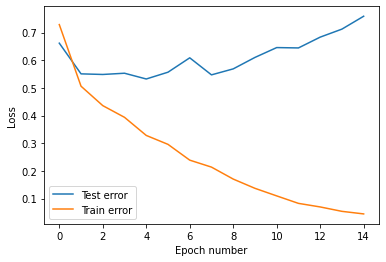

In [ ]:
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

# Model w/batchnorm2d + dropout1d(0.5)
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.5)

# Train
output4 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output4['test_loss'])
plt.plot(output4['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')


Loss train: 0.709	 test: 0.670	 Accuracy train: 52.5%	 test: 56.0%



Loss train: 0.675	 test: 0.653	 Accuracy train: 57.8%	 test: 61.0%



Loss train: 0.641	 test: 0.628	 Accuracy train: 66.1%	 test: 68.7%



Loss train: 0.615	 test: 0.602	 Accuracy train: 68.9%	 test: 71.8%



Loss train: 0.574	 test: 0.582	 Accuracy train: 72.6%	 test: 70.6%



Loss train: 0.552	 test: 0.568	 Accuracy train: 73.8%	 test: 70.9%



Loss train: 0.541	 test: 0.561	 Accuracy train: 75.3%	 test: 71.5%



Loss train: 0.529	 test: 0.574	 Accuracy train: 74.0%	 test: 71.3%



Loss train: 0.516	 test: 0.553	 Accuracy train: 75.7%	 test: 72.4%



Loss train: 0.505	 test: 0.549	 Accuracy train: 76.7%	 test: 72.4%



Loss train: 0.492	 test: 0.546	 Accuracy train: 76.6%	 test: 72.3%



Loss train: 0.496	 test: 0.556	 Accuracy train: 76.6%	 test: 72.3%



Loss train: 0.475	 test: 0.542	 Accuracy train: 78.1%	 test: 72.4%



Loss train: 0.466	 test: 0.562	 Accuracy train: 79.2%	 test: 71.6%



Loss train: 0.463	 test: 0.544	 Accuracy train: 78.9%	 test: 72.6%



Text(0, 0.5, 'Loss')

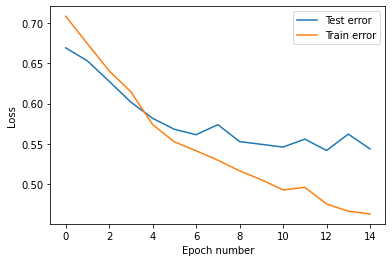

In [ ]:
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

# Model
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

### SGD


Loss train: 0.691	 test: 0.698	 Accuracy train: 52.8%	 test: 48.1%



Loss train: 0.689	 test: 0.691	 Accuracy train: 53.3%	 test: 48.1%



Loss train: 0.686	 test: 0.688	 Accuracy train: 54.7%	 test: 48.2%



Loss train: 0.686	 test: 0.683	 Accuracy train: 54.0%	 test: 65.2%



Loss train: 0.677	 test: 0.679	 Accuracy train: 59.0%	 test: 53.7%



Loss train: 0.669	 test: 0.683	 Accuracy train: 60.9%	 test: 48.9%



Loss train: 0.660	 test: 0.654	 Accuracy train: 62.9%	 test: 66.6%



Loss train: 0.647	 test: 0.633	 Accuracy train: 65.0%	 test: 70.8%



Loss train: 0.612	 test: 0.626	 Accuracy train: 70.3%	 test: 68.2%



Loss train: 0.605	 test: 0.601	 Accuracy train: 67.6%	 test: 70.8%



Loss train: 0.569	 test: 0.572	 Accuracy train: 72.6%	 test: 72.0%



Loss train: 0.550	 test: 0.577	 Accuracy train: 74.6%	 test: 70.1%



Loss train: 0.542	 test: 0.555	 Accuracy train: 74.6%	 test: 71.6%



Loss train: 0.535	 test: 0.563	 Accuracy train: 74.6%	 test: 71.4%



Loss train: 0.529	 test: 0.554	 Accuracy train: 74.8%	 test: 72.2%



Text(0, 0.5, 'Loss')

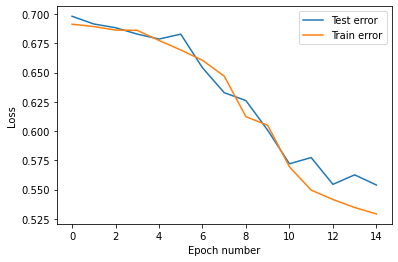

In [ ]:
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

# Model
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')


Loss train: 0.525	 test: 0.545	 Accuracy train: 75.3%	 test: 71.6%



Loss train: 0.510	 test: 0.552	 Accuracy train: 76.4%	 test: 71.9%



Loss train: 0.510	 test: 0.550	 Accuracy train: 76.0%	 test: 72.6%



Loss train: 0.507	 test: 0.545	 Accuracy train: 77.0%	 test: 71.4%



Loss train: 0.502	 test: 0.547	 Accuracy train: 76.9%	 test: 72.4%



Text(0, 0.5, 'Loss')

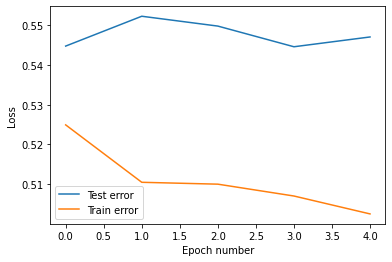

In [ ]:
# Train
output8 = train(model, optimizer, 5)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')


Loss train: 0.496	 test: 0.546	 Accuracy train: 75.8%	 test: 72.6%



Loss train: 0.493	 test: 0.546	 Accuracy train: 77.3%	 test: 71.9%



Loss train: 0.492	 test: 0.543	 Accuracy train: 78.1%	 test: 72.1%



Loss train: 0.492	 test: 0.542	 Accuracy train: 76.9%	 test: 72.1%



Loss train: 0.479	 test: 0.548	 Accuracy train: 78.1%	 test: 72.0%



Text(0, 0.5, 'Loss')

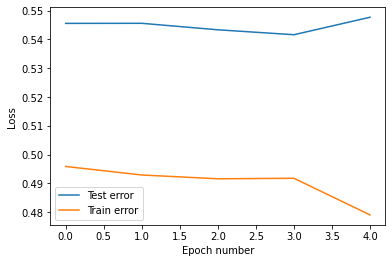

In [ ]:
# Train
output8 = train(model, optimizer, 5)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

## Post data augmentation

### w/batchnorm2d + dropout1d(0.5), 75.9%


Loss train: 0.696	 test: 0.572	 Accuracy train: 62.7%	 test: 70.7%



Loss train: 0.540	 test: 0.553	 Accuracy train: 73.8%	 test: 73.0%



Loss train: 0.498	 test: 0.546	 Accuracy train: 76.4%	 test: 73.0%



Loss train: 0.475	 test: 0.532	 Accuracy train: 77.9%	 test: 73.3%



Loss train: 0.445	 test: 0.521	 Accuracy train: 80.0%	 test: 74.6%



Loss train: 0.434	 test: 0.520	 Accuracy train: 80.6%	 test: 74.5%



Loss train: 0.409	 test: 0.526	 Accuracy train: 82.1%	 test: 75.1%



Loss train: 0.393	 test: 0.533	 Accuracy train: 82.7%	 test: 74.7%



Loss train: 0.371	 test: 0.545	 Accuracy train: 84.2%	 test: 75.2%



Loss train: 0.364	 test: 0.539	 Accuracy train: 84.6%	 test: 74.9%



Loss train: 0.350	 test: 0.584	 Accuracy train: 85.5%	 test: 75.3%



Loss train: 0.340	 test: 0.542	 Accuracy train: 86.5%	 test: 75.9%



Loss train: 0.324	 test: 0.553	 Accuracy train: 86.1%	 test: 75.9%



Loss train: 0.317	 test: 0.556	 Accuracy train: 87.3%	 test: 75.9%



Loss train: 0.311	 test: 0.552	 Accuracy train: 87.3%	 test: 75.2%



Text(0, 0.5, 'Loss')

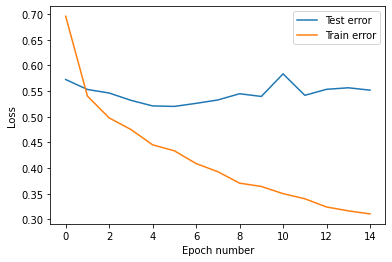

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

# Model w/batchnorm2d + dropout1d(0.5)
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.5)

# Train
output7 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output7['test_loss'])
plt.plot(output7['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

### Model w/batchnorm2d + dropout2d(0.5) + 1*conv2d + dropout1d(0.5), 70.1%


Loss train: 0.706	 test: 0.708	 Accuracy train: 59.4%	 test: 53.0%



Loss train: 0.621	 test: 0.668	 Accuracy train: 66.9%	 test: 60.6%



Loss train: 0.570	 test: 0.591	 Accuracy train: 70.6%	 test: 70.1%



Loss train: 0.538	 test: 0.594	 Accuracy train: 73.3%	 test: 69.9%



Loss train: 0.515	 test: 0.599	 Accuracy train: 74.4%	 test: 69.3%



Loss train: 0.494	 test: 0.600	 Accuracy train: 76.0%	 test: 69.8%



Loss train: 0.473	 test: 0.584	 Accuracy train: 77.5%	 test: 70.1%



Loss train: 0.459	 test: 0.611	 Accuracy train: 78.7%	 test: 68.9%



Loss train: 0.436	 test: 0.620	 Accuracy train: 79.7%	 test: 68.3%



Loss train: 0.422	 test: 0.633	 Accuracy train: 80.5%	 test: 68.9%



Loss train: 0.421	 test: 0.688	 Accuracy train: 80.6%	 test: 64.8%



Loss train: 0.413	 test: 0.720	 Accuracy train: 81.3%	 test: 64.7%



Loss train: 0.406	 test: 0.601	 Accuracy train: 81.1%	 test: 69.4%



Loss train: 0.390	 test: 0.696	 Accuracy train: 81.7%	 test: 67.5%



Loss train: 0.400	 test: 0.624	 Accuracy train: 81.7%	 test: 67.8%



Text(0, 0.5, 'Loss')

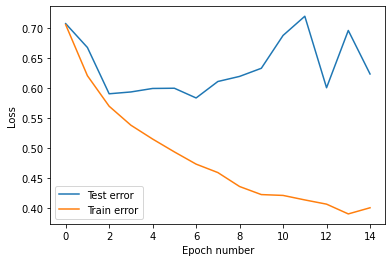

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

# Model w/batchnorm2d + dropout2d(0.5) + 1*conv2d + dropout1d(0.5)
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

### Model w/batchnorm2d + dropout2d(0.5) + 1*conv2d + dropout1d(0.5) + 1*Linear, 70.8%


Loss train: 0.707	 test: 0.691	 Accuracy train: 56.3%	 test: 53.7%



Loss train: 0.661	 test: 0.667	 Accuracy train: 61.6%	 test: 57.0%



Loss train: 0.644	 test: 0.642	 Accuracy train: 63.6%	 test: 65.1%



Loss train: 0.614	 test: 0.643	 Accuracy train: 66.7%	 test: 62.1%



Loss train: 0.589	 test: 0.634	 Accuracy train: 69.5%	 test: 63.3%



Loss train: 0.583	 test: 0.603	 Accuracy train: 69.7%	 test: 67.5%



Loss train: 0.565	 test: 0.621	 Accuracy train: 70.9%	 test: 66.4%



Loss train: 0.535	 test: 0.632	 Accuracy train: 72.9%	 test: 64.9%



Loss train: 0.519	 test: 0.604	 Accuracy train: 74.5%	 test: 67.0%



Loss train: 0.512	 test: 0.602	 Accuracy train: 75.2%	 test: 67.9%



Loss train: 0.498	 test: 0.602	 Accuracy train: 75.3%	 test: 68.4%



Loss train: 0.488	 test: 0.587	 Accuracy train: 76.6%	 test: 70.8%



Loss train: 0.474	 test: 0.642	 Accuracy train: 77.5%	 test: 66.5%



Loss train: 0.459	 test: 0.633	 Accuracy train: 77.8%	 test: 67.5%



Loss train: 0.441	 test: 0.659	 Accuracy train: 78.6%	 test: 69.0%



Text(0, 0.5, 'Loss')

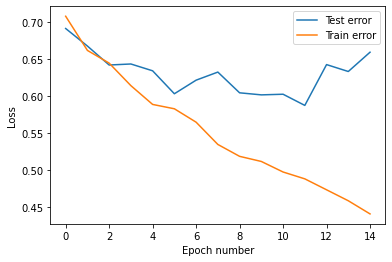

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

# Model w/batchnorm2d + dropout2d(0.5) + 1*conv2d + dropout1d(0.5) + 1*Linear
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

### Dybt netværk


Loss train: 0.708	 test: 0.693	 Accuracy train: 50.7%	 test: 51.8%



Loss train: 0.699	 test: 0.694	 Accuracy train: 50.8%	 test: 48.1%



Loss train: 0.695	 test: 0.694	 Accuracy train: 51.6%	 test: 48.1%



Loss train: 0.692	 test: 0.693	 Accuracy train: 52.6%	 test: 48.1%



Loss train: 0.690	 test: 0.692	 Accuracy train: 53.9%	 test: 49.4%



Loss train: 0.684	 test: 0.689	 Accuracy train: 54.8%	 test: 49.7%



Loss train: 0.677	 test: 0.683	 Accuracy train: 56.5%	 test: 60.7%



Loss train: 0.667	 test: 0.669	 Accuracy train: 60.0%	 test: 64.9%



Loss train: 0.652	 test: 0.646	 Accuracy train: 63.0%	 test: 67.1%



Loss train: 0.628	 test: 0.624	 Accuracy train: 64.7%	 test: 69.2%



Loss train: 0.621	 test: 0.617	 Accuracy train: 66.7%	 test: 69.8%



Loss train: 0.610	 test: 0.608	 Accuracy train: 68.1%	 test: 70.1%



Loss train: 0.599	 test: 0.606	 Accuracy train: 68.3%	 test: 70.2%



Loss train: 0.594	 test: 0.605	 Accuracy train: 69.0%	 test: 70.6%



Loss train: 0.592	 test: 0.605	 Accuracy train: 69.5%	 test: 70.4%



Text(0, 0.5, 'Loss')

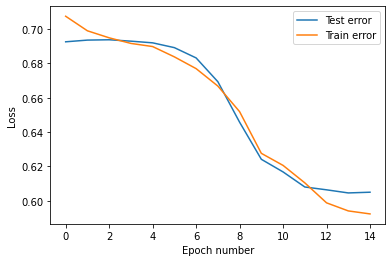

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

# Model w/batchnorm2d + dropout2d(0.5) + 10*conv2d + dropout1d(0.5) + 2*Linear(i alt)
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')


Loss train: 0.589	 test: 0.596	 Accuracy train: 69.6%	 test: 70.6%



Loss train: 0.586	 test: 0.589	 Accuracy train: 70.4%	 test: 71.3%



Loss train: 0.583	 test: 0.584	 Accuracy train: 69.8%	 test: 71.1%



Loss train: 0.582	 test: 0.599	 Accuracy train: 70.2%	 test: 71.2%



Loss train: 0.573	 test: 0.598	 Accuracy train: 70.7%	 test: 71.2%



Loss train: 0.574	 test: 0.603	 Accuracy train: 70.2%	 test: 70.7%



Loss train: 0.570	 test: 0.605	 Accuracy train: 70.4%	 test: 71.1%



Loss train: 0.568	 test: 0.595	 Accuracy train: 71.4%	 test: 71.4%



Loss train: 0.567	 test: 0.598	 Accuracy train: 71.6%	 test: 71.1%



Loss train: 0.562	 test: 0.589	 Accuracy train: 71.4%	 test: 71.7%



Loss train: 0.563	 test: 0.594	 Accuracy train: 71.3%	 test: 71.4%



Loss train: 0.558	 test: 0.591	 Accuracy train: 72.2%	 test: 71.3%



Loss train: 0.561	 test: 0.587	 Accuracy train: 72.0%	 test: 71.4%



Loss train: 0.557	 test: 0.594	 Accuracy train: 71.7%	 test: 71.6%



Loss train: 0.559	 test: 0.591	 Accuracy train: 71.9%	 test: 71.5%



Text(0, 0.5, 'Loss')

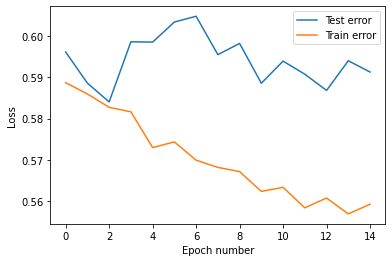

In [ ]:
# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

### num_features = 5120


Loss train: 0.736	 test: 0.691	 Accuracy train: 49.9%	 test: 53.7%



Loss train: 0.703	 test: 0.692	 Accuracy train: 52.7%	 test: 53.5%



Loss train: 0.697	 test: 0.699	 Accuracy train: 53.1%	 test: 48.1%



Loss train: 0.691	 test: 0.702	 Accuracy train: 53.5%	 test: 48.0%



Loss train: 0.673	 test: 0.677	 Accuracy train: 58.8%	 test: 59.3%



Loss train: 0.650	 test: 0.686	 Accuracy train: 62.4%	 test: 53.0%



Loss train: 0.625	 test: 0.666	 Accuracy train: 65.2%	 test: 57.3%



Loss train: 0.606	 test: 0.621	 Accuracy train: 67.6%	 test: 65.1%



Loss train: 0.594	 test: 0.607	 Accuracy train: 69.1%	 test: 65.7%



Loss train: 0.592	 test: 0.586	 Accuracy train: 68.7%	 test: 69.2%



Loss train: 0.584	 test: 0.597	 Accuracy train: 69.4%	 test: 67.0%



Loss train: 0.578	 test: 0.595	 Accuracy train: 69.9%	 test: 66.8%



Loss train: 0.578	 test: 0.587	 Accuracy train: 70.1%	 test: 67.2%



Loss train: 0.574	 test: 0.585	 Accuracy train: 70.3%	 test: 68.2%



Loss train: 0.567	 test: 0.580	 Accuracy train: 71.0%	 test: 69.4%



Loss train: 0.562	 test: 0.570	 Accuracy train: 71.2%	 test: 69.5%



Loss train: 0.560	 test: 0.574	 Accuracy train: 70.9%	 test: 69.7%



Loss train: 0.559	 test: 0.578	 Accuracy train: 70.8%	 test: 69.7%



Loss train: 0.552	 test: 0.567	 Accuracy train: 71.8%	 test: 71.4%



Loss train: 0.550	 test: 0.573	 Accuracy train: 72.2%	 test: 70.2%



Text(0, 0.5, 'Loss')

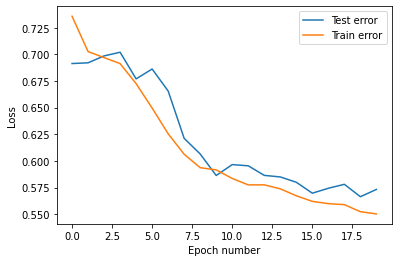

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 20
num_features = 5120

# Model w/batchnorm2d + dropout2d(0.5) + 10*conv2d + dropout1d(0.5) + 2*Linear(i alt)
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')


Loss train: 0.574	 test: 0.589	 Accuracy train: 69.9%	 test: 69.7%



Loss train: 0.495	 test: 0.539	 Accuracy train: 76.0%	 test: 73.5%



Loss train: 0.453	 test: 0.534	 Accuracy train: 78.9%	 test: 74.6%



Loss train: 0.429	 test: 0.586	 Accuracy train: 80.4%	 test: 71.4%



Loss train: 0.393	 test: 0.561	 Accuracy train: 82.9%	 test: 74.0%



Loss train: 0.372	 test: 0.576	 Accuracy train: 84.2%	 test: 73.4%



Loss train: 0.346	 test: 0.540	 Accuracy train: 85.3%	 test: 75.3%



Loss train: 0.341	 test: 0.572	 Accuracy train: 86.2%	 test: 74.5%



Loss train: 0.314	 test: 0.591	 Accuracy train: 87.3%	 test: 75.2%



Loss train: 0.305	 test: 0.576	 Accuracy train: 87.6%	 test: 75.1%



Loss train: 0.291	 test: 0.603	 Accuracy train: 88.0%	 test: 74.6%



Loss train: 0.288	 test: 0.565	 Accuracy train: 88.1%	 test: 75.4%



Loss train: 0.277	 test: 0.602	 Accuracy train: 88.7%	 test: 74.9%



Loss train: 0.278	 test: 0.581	 Accuracy train: 88.9%	 test: 74.9%



Loss train: 0.267	 test: 0.571	 Accuracy train: 89.4%	 test: 74.5%



Text(0, 0.5, 'Loss')

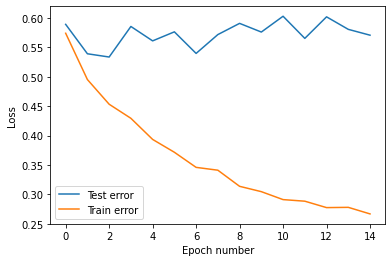

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 15
num_features = 512

# Model w/batchnorm2d + 3*conv2d + dropout1d(0.5) + 1*Linear
model = Network()
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

##Save model state

In [ ]:
tid_andel=datetime.datetime.today()
dato = tid_andel.strftime("%d-%b-%H:%M")

torch.save(model.state_dict(), 'gdrive/My Drive/DLiCV_project/Project1/modelsaved'+dato)
torch.save(optimizer.state_dict(), 'gdrive/My Drive/DLiCV_project/Project1/optimsaved'+dato)

##Load model state

In [ ]:
model = Network().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.load_state_dict(torch.load('gdrive/My Drive/DLiCV_project/Project1/modelsaved'+dato))
optimizer.load_state_dict(torch.load('gdrive/My Drive/DLiCV_project/Project1/optimsaved'+dato))

# Predict

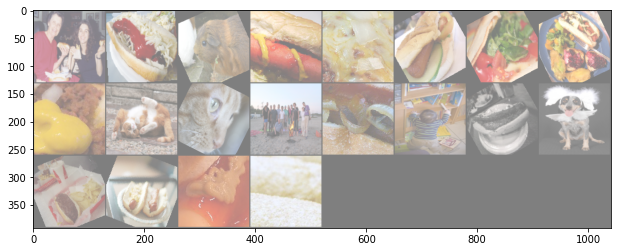

GroundTruth:  Hotdog Hotdog Not-hotdog Hotdog Hotdog Hotdog Not-hotdog Hotdog Hotdog Not-hotdog Not-hotdog Not-hotdog Hotdog Not-hotdog Hotdog Not-hotdog Hotdog Hotdog Hotdog Hotdog


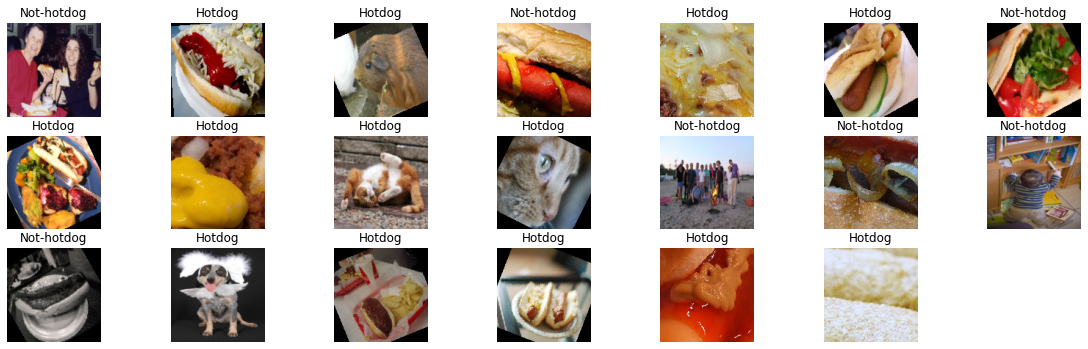

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

N_pic=20

classes = ( 'Hotdog','Not-hotdog')

# print images
imshow(torchvision.utils.make_grid(images[0:N_pic]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(N_pic)))

outputs_predict = model(images[0:N_pic].to(device))

_, predicted = torch.max(outputs_predict, 1)

#print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                              for j in range(8)))

# What the model predicts:

plt.figure(figsize=(20,10))

for i in range(N_pic):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(classes[predicted[i]])
    plt.axis('off')

# ResNet

### 10 res blocks

In [ ]:
def Padding(kernel_size):
  padding = int((kernel_size-1)/2)
  return padding

class ResNetBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResNetBlock, self).__init__()
        self.conv1=nn.Conv2d(in_channels,in_channels, kernel_size=3, stride=1, padding=1)
        self.activation=nn.ReLU()
 #       self.drop=nn.Dropout2d(0.5)
        self.batch=nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out= self.activation(self.conv1(x))
     #   out= self.drop(out)
        out= self.batch(out)
        out+=residual
        out=self.activation(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_res_blocks=3):
        super(ResNet, self).__init__()
        
        conv_layers = [nn.Conv2d(n_in, in_channels, kernel_size=3, stride=1, padding=1),
                       nn.ReLU(), nn.BatchNorm2d(in_channels)]# nn.Dropout2d(0.5), ]

        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(in_channels))
            if i == num_res_blocks-1:
                conv_layers.append(nn.MaxPool2d(2))


        self.res_blocks = nn.Sequential(*conv_layers)

        self.fully_connected = nn.Sequential(
            nn.Linear(64*64*in_channels, num_features),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_features, num_features),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_features, no_targets),
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x


Loss train: 1.285	 test: 0.682	 Accuracy train: 51.7%	 test: 56.3%



Loss train: 0.854	 test: 0.672	 Accuracy train: 53.9%	 test: 59.7%



Loss train: 0.802	 test: 0.677	 Accuracy train: 55.3%	 test: 57.9%



Loss train: 0.753	 test: 0.688	 Accuracy train: 55.3%	 test: 52.1%



Loss train: 0.734	 test: 0.698	 Accuracy train: 56.7%	 test: 49.9%



Loss train: 0.716	 test: 0.686	 Accuracy train: 57.6%	 test: 56.6%



Loss train: 0.692	 test: 0.682	 Accuracy train: 59.0%	 test: 54.4%



Loss train: 0.683	 test: 0.676	 Accuracy train: 60.5%	 test: 59.5%



Loss train: 0.672	 test: 0.682	 Accuracy train: 61.0%	 test: 56.8%



Loss train: 0.671	 test: 0.674	 Accuracy train: 61.3%	 test: 58.5%



Loss train: 0.642	 test: 0.664	 Accuracy train: 63.9%	 test: 61.8%



Loss train: 0.654	 test: 0.669	 Accuracy train: 64.1%	 test: 59.3%



Loss train: 0.632	 test: 0.666	 Accuracy train: 65.3%	 test: 60.1%



Loss train: 0.634	 test: 0.685	 Accuracy train: 64.4%	 test: 56.3%



Loss train: 0.621	 test: 0.677	 Accuracy train: 66.9%	 test: 58.8%



Loss train: 0.611	 test: 0.662	 Accuracy train: 66.6%	 test: 60.4%



Loss train: 0.613	 test: 0.683	 Accuracy train: 66.4%	 test: 57.3%



Loss train: 0.608	 test: 0.672	 Accuracy train: 67.9%	 test: 59.0%



Loss train: 0.590	 test: 0.667	 Accuracy train: 68.8%	 test: 62.1%



Loss train: 0.597	 test: 0.670	 Accuracy train: 68.2%	 test: 61.8%



Text(0, 0.5, 'Loss')

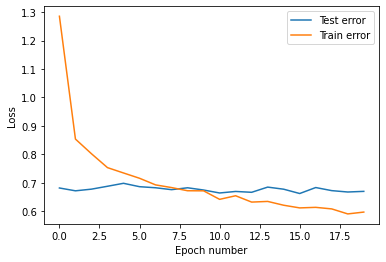

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 20
num_features = 5120
n_in = 3

# Model w/batchnorm2d + dropout2d(0.5) + 10*conv2d + dropout1d(0.5) + 2*Linear(i alt)
model = ResNet(num_res_blocks = 10)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')


Loss train: 1.376	 test: 1.006	 Accuracy train: 53.7%	 test: 51.9%



Loss train: 0.885	 test: 0.862	 Accuracy train: 59.5%	 test: 51.1%



Loss train: 0.760	 test: 0.729	 Accuracy train: 62.7%	 test: 57.7%



Loss train: 0.685	 test: 0.727	 Accuracy train: 68.2%	 test: 58.9%



Loss train: 0.606	 test: 0.687	 Accuracy train: 71.7%	 test: 60.3%



Loss train: 0.545	 test: 0.665	 Accuracy train: 75.9%	 test: 65.1%



Loss train: 0.538	 test: 0.654	 Accuracy train: 76.0%	 test: 64.3%



Loss train: 0.474	 test: 0.654	 Accuracy train: 79.0%	 test: 65.4%



Loss train: 0.419	 test: 0.662	 Accuracy train: 81.7%	 test: 66.1%



Loss train: 0.422	 test: 0.646	 Accuracy train: 82.0%	 test: 66.4%



Loss train: 0.370	 test: 0.658	 Accuracy train: 83.0%	 test: 69.0%



Loss train: 0.354	 test: 0.663	 Accuracy train: 84.3%	 test: 69.0%



Loss train: 0.343	 test: 0.662	 Accuracy train: 85.0%	 test: 68.5%



Loss train: 0.345	 test: 0.651	 Accuracy train: 84.6%	 test: 68.2%



Loss train: 0.322	 test: 0.660	 Accuracy train: 85.2%	 test: 68.4%



Loss train: 0.307	 test: 0.712	 Accuracy train: 86.3%	 test: 67.2%



Loss train: 0.317	 test: 0.675	 Accuracy train: 86.1%	 test: 69.2%



Loss train: 0.305	 test: 0.704	 Accuracy train: 86.9%	 test: 68.5%



Loss train: 0.281	 test: 0.663	 Accuracy train: 87.9%	 test: 68.7%



Loss train: 0.279	 test: 0.647	 Accuracy train: 87.6%	 test: 70.1%



Text(0, 0.5, 'Loss')

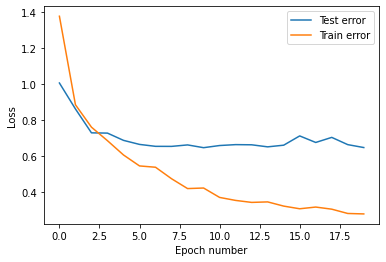

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 20
num_features = 5120
n_in = 3

# Model w/batchnorm2d + 10*conv2d + dropout1d(0.5) + 2*Linear(i alt)
model = ResNet(num_res_blocks = 10)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

### 18 res blocks


Loss train: 2.160	 test: 0.752	 Accuracy train: 56.2%	 test: 58.5%



Loss train: 1.116	 test: 0.768	 Accuracy train: 59.7%	 test: 57.6%



Loss train: 0.871	 test: 0.680	 Accuracy train: 63.3%	 test: 62.9%



Loss train: 0.734	 test: 0.681	 Accuracy train: 66.9%	 test: 64.1%



Loss train: 0.665	 test: 0.660	 Accuracy train: 70.2%	 test: 63.7%



Loss train: 0.597	 test: 0.726	 Accuracy train: 72.1%	 test: 63.9%



Loss train: 0.549	 test: 0.680	 Accuracy train: 74.6%	 test: 64.8%



Loss train: 0.520	 test: 0.701	 Accuracy train: 76.4%	 test: 65.3%



Loss train: 0.490	 test: 0.740	 Accuracy train: 77.6%	 test: 64.8%



Loss train: 0.470	 test: 0.708	 Accuracy train: 78.1%	 test: 64.7%



Loss train: 0.454	 test: 0.803	 Accuracy train: 79.0%	 test: 64.0%



Loss train: 0.437	 test: 0.789	 Accuracy train: 80.1%	 test: 62.3%



Loss train: 0.433	 test: 0.727	 Accuracy train: 80.0%	 test: 63.9%



Loss train: 0.396	 test: 0.788	 Accuracy train: 81.4%	 test: 64.9%



Loss train: 0.397	 test: 0.772	 Accuracy train: 81.1%	 test: 62.4%



Loss train: 0.405	 test: 0.742	 Accuracy train: 81.3%	 test: 62.7%



Loss train: 0.389	 test: 0.801	 Accuracy train: 82.0%	 test: 62.2%



Loss train: 0.383	 test: 0.725	 Accuracy train: 82.3%	 test: 64.4%



Loss train: 0.372	 test: 0.704	 Accuracy train: 82.8%	 test: 64.1%



Loss train: 0.355	 test: 0.728	 Accuracy train: 83.0%	 test: 63.7%



Text(0, 0.5, 'Loss')

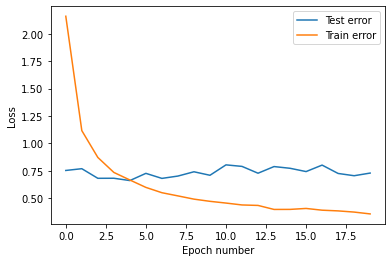

In [ ]:
# incl. data augmentation
# Hyperparameters
in_channels = 3
out_channels = 6
kernel_size = 3
stride = 1
no_targets=2
num_epochs = 20
num_features = 5120
n_in = 3

# Model w/batchnorm2d + 10*conv2d + dropout1d(0.5) + 2*Linear(i alt)
model = ResNet(num_res_blocks = 18)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train
output8 = train(model, optimizer, num_epochs)

# Plot
plt.plot(output8['test_loss'])
plt.plot(output8['train_loss'])
plt.legend(('Test error','Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')